# Прогнозирование оттока клиентов телеком-компании

# План работы:

1) [**Предобработка и анализ данных:**](#step1)
- проверка типов на соответствие данным (преобразование типов данных  там, где нужно - строки в числа, в даты и т.д., там где необходимо или это сделать потом, когда выберем признаки в модель, а в этом пункте просто описание данных), 
- проверка адекватности данных - пропуски, дубликаты, аномалии
- анализ данных (зависимости\закономерности - поможет определиться с выбором/созданием признаком в модель) 

2) [**Подготовка данных к моделированию:**](#step2)
- выбор признаков в модель (признаки из разных таблиц, объединение таблиц - разное количество наблюдений в таблицах: есть контракт - нет информации об интернет-услугах, услугах телефонии), создание признаков - например, сколько дней/месяцев длится контракт и тп.
- преобразование категориальных признаков
- разделить данные на обучающую и тестовую выборки

3) [**Построение моделей (+подбор гиперпараметров), тестирование и оценка моделей, выбор наилучшей:**](#step3)
- несколько моделей/подбор гиперпараметров
- тестирование и оценка моделей
- выбор наилучшей модели

4) [**Отчет о проделанной работе**](#step3)


# Шаг 1. Предобработка и анализ данных <a id='step1'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, accuracy_score

Ознакомимся с данными и сделаем первые выводы:

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [10]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


Всего контрактов в выборке - 7043, из них интернет-услугами пользуются 5517 пользователей, услугами телефонии - 6361 пользователь. 

Таблица `contract` - признак **TotalCharges** необходимо перевести в числовой тип. Также в **TotalCharges** есть пустые строки c пробелом - преобразовать в 0. **EndDate** - целевой признак, преобразовать в boolean, где 0 - не ушел, 1 - ушел, на основании данных **BeginDate** и **EndDate** можно создать новый признак - какое количество времени пользователь является/являлся клиентом данного оператора связи - однако этот признак, наверняка будет сильно корреллироваться с **TotalCharges** - чем больше времени пользуется\пользовался, тем больше уже оплатил. Проверим это предположение далее, и выберем для модели наиболее значимый признак.

Таблица `personal` - содержит персональные данные, на мой взгляд бесполезна для данной задачи, врядли, например, от пола пользоват зависит уйдет клиент или не уйдет, информация из этой таблицы скорее поможет маркетологам на этапе формирования предложений при разработке способов удержания.

Таблица `internet` - чтобы не загромождать модель признаками, можно все дополнительные услуги OnlineSecurity, OnlineBacku, DeviceProtection	TechSupport, Streamin, StreamingMovies - заменить одним столбцом, значения в котором равны чсилу всех подключенных услуг, например, назовем его **AddServicesCount** - количество дополнительных услуг - это будет признак лояльности клиента к данному оператору, чем лояльнее клиент, тем больше доп. услуг подключено.

Таблица `phone` - имеет только один признак подключен к нескольким линиям одновременно или нет - нужно только преобразовать этот признак из категориального в числовой.


# Шаг 2. Подготовка данных к моделированию <a id='step2'></a>

- изменим тип TotalCharges: сначала заменив пробелы на 0, так как это клиенты-новички, сдуя по дате начала договора, они еще не успели ничего оплатить

In [11]:
contract.loc[contract['TotalCharges'] == " ", 'TotalCharges'] = 0
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

- преобразование типа данных в целевом признаке

In [12]:
contract['EndDateGoal'] = contract['EndDate']
contract.loc[contract['EndDateGoal'] == "No", 'EndDateGoal'] = 0
contract.loc[contract['EndDateGoal'] !=0, 'EndDateGoal'] = 1

- добавление признака DaysCount - сколько дней является пользователем

In [13]:
contract.loc[contract['EndDate'] == "No", 'EndDate'] = "2020-02-01"

In [14]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [15]:
contract['DaysCount'] = (contract['EndDate'] - contract['BeginDate'])/pd.to_timedelta('1D')

- создание признака AddServicesCount - количество подключенных дополнительных услуг

In [16]:
internet['AddServicesCount'] = (internet[['OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']] == "Yes").sum(1)

- объединение таблиц в одну, просто для удобства дальнейшей работы с признаками :

In [17]:
all_data = contract[['customerID','Type','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges','EndDateGoal','DaysCount']].merge(internet[['customerID','InternetService','AddServicesCount']],on=['customerID'],how='outer')
all_data = all_data.merge(phone,on=['customerID'],how='outer')

- проверка корреляции признаков (числовые признаки есть только в 

In [18]:
all_data.head(3)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateGoal,DaysCount,InternetService,AddServicesCount,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31.0,DSL,1.0,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036.0,DSL,2.0,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61.0,DSL,2.0,No


In [19]:
def corrspearman(data):
    parameters = data
    plt.figure(figsize = (5,5))
    corr=parameters.corr(method='spearman')
    sns.heatmap(corr,annot=True, fmt=".2f")

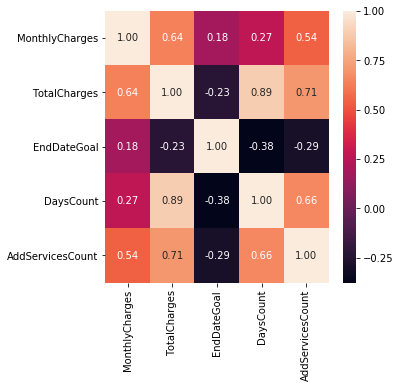

In [20]:
corrspearman(all_data)

Как и предополагалось корреляция между DaysCount и TotalCharges очень сильная: коэффициент корреляции - 0.89. Один из признаков можно убрать из модели. TotalCharge, в том числе зависит и от подключенных услуг, их количества, которые у нас все есть в модели, и с MonthlyCharges  у него достаточно высокий коэффициент корреляции, таким образом можно предположить, что лучше убрать TotalCharge. Это подтвердилось и опытным путем, модель с признаком DaysCount - показала более хорошее качество метрики. 

- уберем ненужные для модели признак:

In [21]:
all_data = all_data.drop(['customerID'], axis=1)

- при объединении таблиц появились пропуски (так как не все пользуются интернет-услугами или услугами телефонии). Так и обработаем пропуски - это будет новая категория "не пользуется":

In [22]:
all_data['InternetService'] = all_data['InternetService'].fillna("not use")
all_data['AddServicesCount'] = all_data['AddServicesCount'].fillna(0)
all_data['MultipleLines'] = all_data['MultipleLines'].fillna("not use")

- преобразуем категориальные признаки методом прямого кодирования

In [23]:
categoriсal = list(all_data.select_dtypes(include = 'object').columns)
numeric = ['MonthlyCharges','DaysCount','AddServicesCount']

Примечание: (TotalCharges - на этом этапе в итоговом варианте работы сразу не берем в модель, так как он скоррелирован сильно DaysCount, а DaysCount - оказался более значимый признак для модели)

In [24]:
all_data_categoriсal = pd.get_dummies(all_data[categoriсal], drop_first=True)

- поделим на features и target:

In [25]:
features = pd.concat([all_data_categoriсal, all_data[numeric]],axis=1)
target = all_data['EndDateGoal']

- поделим на train и test:

In [26]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345, stratify=target)

In [27]:
all_data.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateGoal,DaysCount,InternetService,AddServicesCount,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,31.0,DSL,1.0,not use
1,One year,No,Mailed check,56.95,1889.50,0,1036.0,DSL,2.0,No
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,61.0,DSL,2.0,No


# Шаг 3. Построение моделей (+подбор гиперпараметров), тестирование и оценка моделей, выбор наилучшей: <a id='step3'></a>

Начнем с простейшей модели классификации LogisticRegression:

In [28]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)

probabilities_test = model.predict_proba(features_train)
probabilities_one_test = probabilities_test[:, 1]
auc_roc_LogisticRegression = roc_auc_score(target_train, probabilities_one_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc_LogisticRegression_test = roc_auc_score(target_test, probabilities_one_test)

accuracy_score_LogisticRegression = accuracy_score(target_test, model.predict(features_test))

Далее попробуем случайный лес RandomForestClassifier:

In [29]:
estimator = RandomForestClassifier(random_state=12345, class_weight = "balanced")

param_grid = {
    'n_estimators': [20,30,40,50,60,70]
}

model = GridSearchCV(estimator, param_grid, cv=3, scoring = 'roc_auc')
model.fit(features_train, target_train)
model.best_params_

{'n_estimators': 70}

In [30]:
auc_roc_RandomForestClassifier = model.best_score_

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc_RandomForestClassifier_test = roc_auc_score(target_test, probabilities_one_test)

accuracy_score_RandomForestClassifier = accuracy_score(target_test, model.predict(features_test))

И напоследок одну из моделей градиентного бустинга LGBMClassifier:

In [31]:
%%time
estimator = LGBMClassifier()

param_grid = {
    
    'max_depth': [20,30,40],
    'num_leaves': [30,40,50]
}

modellgb = GridSearchCV(estimator, param_grid, cv=3, scoring = 'roc_auc')
modellgb.fit(features_train, target_train)
modellgb.best_params_

CPU times: user 44 s, sys: 780 ms, total: 44.8 s
Wall time: 45.4 s


{'max_depth': 20, 'num_leaves': 40}

In [32]:
auc_roc_LGBMClassifier = modellgb.best_score_

probabilities_test = modellgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc_LGBMClassifier_test = roc_auc_score(target_test, probabilities_one_test)

accuracy_score_LGBMClassifier = accuracy_score(target_test, model.predict(features_test))

Сравним основные метрики моделей на обучающей выборке и тестовой выборках, а также дополнительные метрики:

In [33]:
result = pd.DataFrame({
    'model': [
        'LogisticRegression', 
        'RandomForestClassifier', 
        'LGBMClassifier'], 
    'roc_auc': [
        auc_roc_LogisticRegression, 
        auc_roc_RandomForestClassifier, 
        auc_roc_LGBMClassifier],
    'roc_auc_test': [
        auc_roc_LogisticRegression_test, 
        auc_roc_RandomForestClassifier_test, 
        auc_roc_LGBMClassifier_test],
    'accuracy_score': [
        accuracy_score_LogisticRegression, 
        accuracy_score_RandomForestClassifier, 
        accuracy_score_LGBMClassifier]
})

In [34]:
result

,model,roc_auc,roc_auc_test,accuracy_score
0,LogisticRegression,0.842928,0.834487,0.797842
1,RandomForestClassifier,0.825742,0.824735,0.798978
2,LGBMClassifier,0.885310,0.889194,0.798978


Итак, наилучший результат показала модель LGBMClassifier - и на обучающей выборке и на тестовой выборках достигнуто максимальное значение метрики из трех. Основная задача - достижение целевой метрики roc_auc определенных значений - выполнена. В работе не потребовалось каких-то сложных обработок данных, был добавлен один дополнительный признак количество дней пользования услугами, и несколько признаков заменены одним. Отдельному анализу подлежит разработка модели удержания клиентом, для этого нужно будет разбить клиентов на группы по разным признакам, оценить кто входит в эти группы, кто чаще уходит. Возможно для этого пригодятся данные из таблицы personal, а данной задаче признаки из этой таблицы не использовались. 

# Доработка: графический анализ важности признаков

Этот блок повторяется из проекта, только берутся все признаки, что даны, без анализа:

In [35]:
all_data_check = contract[['customerID','Type','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges','EndDateGoal','DaysCount']].merge(internet[['customerID','InternetService','AddServicesCount']],on=['customerID'],how='outer')
all_data_check = all_data_check.merge(phone,on=['customerID'],how='outer')
all_data_check = all_data_check.merge(personal,on=['customerID'],how='left')
all_data_check = all_data_check.drop(['customerID'], axis=1)
all_data_check['InternetService'] = all_data_check['InternetService'].fillna("not use")
all_data_check['AddServicesCount'] = all_data_check['AddServicesCount'].fillna(0)
all_data_check['MultipleLines'] = all_data_check['MultipleLines'].fillna("not use")

In [36]:
all_data_check.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateGoal,DaysCount,InternetService,AddServicesCount,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,31.0,DSL,1.0,not use,Female,0,Yes,No
1,One year,No,Mailed check,56.95,1889.50,0,1036.0,DSL,2.0,No,Male,0,No,No
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,61.0,DSL,2.0,No,Male,0,No,No
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371.0,DSL,3.0,not use,Male,0,No,No
4,Month-to-month,Yes,Electronic check,70.70,151.65,1,61.0,Fiber optic,0.0,No,Female,0,No,No


In [37]:
categoriсal_check = list(all_data_check.select_dtypes(include = 'object').columns)
numeric_check = ['MonthlyCharges','DaysCount','AddServicesCount','TotalCharges']

In [38]:
all_data_categoriсal_check = pd.get_dummies(all_data_check[categoriсal_check], drop_first=True)

In [39]:
categoriсal_check

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'MultipleLines',
 'gender',
 'Partner',
 'Dependents']

In [40]:
features = pd.concat([all_data_categoriсal_check, all_data_check[numeric_check]],axis=1)
target = all_data_check['EndDateGoal']

In [41]:
features.shape

(7043, 17)

In [42]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345, stratify=target)

In [43]:
%%time
estimator = LGBMClassifier()

param_grid = {
    
    'max_depth': [20,30,40],
    'num_leaves': [30,40,50]
}

modellgb = GridSearchCV(estimator, param_grid, cv=3, scoring = 'roc_auc')
modellgb.fit(features_train, target_train)
modellgb.best_params_

CPU times: user 48.9 s, sys: 798 ms, total: 49.7 s
Wall time: 50.4 s


{'max_depth': 20, 'num_leaves': 30}

Метрика на при обучении при полном наборе признаков:

In [44]:
modellgb.best_score_

0.8804761875782019

Метрика на тестовой выборке при полном наборе признаков:

In [45]:
probabilities_test = modellgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_score(target_test, probabilities_one_test)

0.8840017673399547

In [46]:
modellgb = LGBMClassifier(max_depth=20, num_leaves=40)
modellgb.fit(features_train, target_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=20,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=40, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

График важности факторов модели:

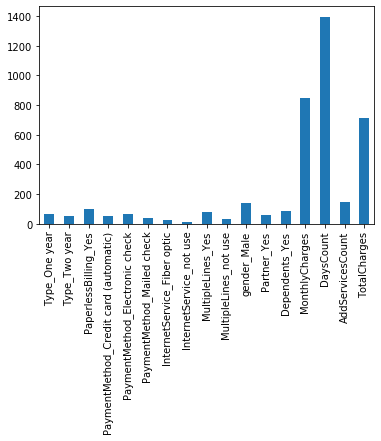

In [47]:
pd.Series(modellgb.feature_importances_, index = features.columns).plot(kind='bar')

Метрика изменилась на тысячные доли. Радует, что сгенерированные фичи DaysCount и AddServiecesCount - оказались значимыми для модели. А то возникает чувство, что вся предварительная работа в данной задаче не особо нужна) Сходу заливай всё в модель и результат уже неплохой)

Попробуем оставить в модели только значимые признаки:

In [48]:
features.columns

Index(['Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_not use',
       'MultipleLines_Yes', 'MultipleLines_not use', 'gender_Male',
       'Partner_Yes', 'Dependents_Yes', 'MonthlyCharges', 'DaysCount',
       'AddServicesCount', 'TotalCharges'],
      dtype='object')

In [49]:
features = features[['DaysCount','MonthlyCharges','AddServicesCount','gender_Male','PaperlessBilling_Yes','MultipleLines_Yes','Partner_Yes','Dependents_Yes']]

In [50]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345, stratify=target)

In [51]:
%%time
estimator = LGBMClassifier()

param_grid = {
    
    'max_depth': [20,30,40],
    'num_leaves': [30,40,50]
}

modellgb = GridSearchCV(estimator, param_grid, cv=3, scoring = 'roc_auc')
modellgb.fit(features_train, target_train)
modellgb.best_params_

CPU times: user 43.9 s, sys: 726 ms, total: 44.7 s
Wall time: 45.3 s


{'max_depth': 30, 'num_leaves': 50}

In [52]:
modellgb.best_score_

0.879222870802242

In [53]:
probabilities_test = modellgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_score(target_test, probabilities_one_test)

0.8858261983326107

# Шаг 4. Отчет о проделанной работе <a id='step4'></a>

В данной проекте необходимо было решить задачу классификации - построить модель для прогнозирования оттока клиентов и достичь при этом заданного уровня метрики.  

На первом этапе мы познакомились с данными и их структурой, с типами данных. Оценили качество данных - наличие пропусков, аномалий. Проанализировали информацию из разных таблиц, чтобы понять взиамосвязи, логику данных. 

На следующем этапе - подготовили данные к моделированию: 
- избавились от пропусков, преобразовали типы данных, где это было необходимо, 
- добавили новые признаки на основании анализа и умозаключений из первого этапа проекта,
- выбрали наиболее значимые признаки в модель
- поделили на обучующую и тестовую выборки

На последнем этапе обучали, подбирали гиперпараметры и тестировали несколько моделей - начали с простой логистической регрессии, случайный лес, и градиентный бустинг.

После доработки проекта - добавлен графический анализ важности признаков. До этого признаки в модель отбирались просто логически и опытным путем - обучая модели с разным набором признаков и оценивая метрику.

По итогу выполнения задачи лучший результат показала модель градиентоного бустинга LGBMClassifier, которая показала максимальные метрики - 0.885 на валидации и 0.889 на тестовой выборке - это максимальный критерий оценки. Итоговая таблица результатов:

In [54]:
result

,model,roc_auc,roc_auc_test,accuracy_score
0,LogisticRegression,0.842928,0.834487,0.797842
1,RandomForestClassifier,0.825742,0.824735,0.798978
2,LGBMClassifier,0.885310,0.889194,0.798978
